In [351]:
from PreProcessingBASD import *
import numpy as np
import shap
import pandas as pd
import matplotlib.pyplot as plt

https://github.com/sungreong/MEDIUM_NoteBook/blob/master/NeuralNet_FeatureImportance/NeuralNet_FeatImportance.ipynb

In [352]:
data = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-train-0.2-0.0.csv")
in_var = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
          "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
          "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
target_var = ['default payment next month']
fac_var = [ 'SEX','EDUCATION','MARRIAGE',]
num_var = [i for i in in_var if not i in fac_var]
#in_var = num_var + fac_var
data[fac_var] = data[fac_var].astype("category")
cat_col = data.select_dtypes("category").columns.tolist()
onehot_data = pd.get_dummies(data , columns= cat_col)
select_var = in_var + target_var + ["sep_idx"]
train = data[select_var]
_ = train.pop("sep_idx")
# data = data[select_var]
# train = data[data.sep_idx ==1 ]
# valid = data[data.sep_idx ==0 ]
# _ = train.pop("sep_idx")
# _ = valid.pop("sep_idx")
#train = train.loc[~(train.purpose == "educational"),:]
train.reset_index(drop=True , inplace = True)
# valid.reset_index(drop=True , inplace = True)
test = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-test-0.2-0.0.csv")

In [353]:
test.pop("sep_idx")
test.pop("ID")
test.reset_index(drop=True , inplace = True)

In [354]:
trans_info = {}
[["normal",{}],["sklearn:standard",{}],
 ["sklearn:minmax",{"feature_range" : (-1,1)}],
 ["sklearn:robust",{}],
 ["sklearn:quantile",{"n_quantiles" : 20}]]

Steps = [
    ("Outlier", OutlierTransformer(method="modified-z-score", 
                               trans_info= trans_info,
                               multiple_outlier_n = 4,
                               var= num_var)) , 
    ("NumericImpute", MissingHandling(method="mean", 
                               trans_info= trans_info,
                               var= num_var)) , 
    ("FactorImpute", MissingHandling(method="most_frequent", 
                               trans_info= trans_info,
                               var= fac_var)) , 
    ("numeric", NumericHandler(method="sklearn:minmax",
                               trans_info= trans_info,
                               num_var=num_var,
                               method_option = {"feature_range" : (-1,1)}
                              )),
    ('category', CategoryHandler(trans_info= trans_info, 
                                 method= "onehot",
                                 num_var = num_var , 
                                 in_var = in_var,
                                 target_var= target_var,
                                 dummy_na = False
                                ))
]
pipe = Pipeline(Steps)
pipe.fit(train)
##

Transform MissingData Method : mean
Transform MissingData Method : most_frequent
Transform NumericData


Pipeline(memory=None,
         steps=[('Outlier',
                 OutlierTransformer(method='modified-z-score',
                                    multiple_outlier_n=4,
                                    trans_info={'Outlier': {'AGE': None,
                                                            'BILL_AMT1': None,
                                                            'BILL_AMT2': None,
                                                            'BILL_AMT3': None,
                                                            'BILL_AMT4': None,
                                                            'BILL_AMT5': None,
                                                            'BILL_AMT6': None,
                                                            'LIMIT_BAL': None,
                                                            'PAY_0': None,
                                                            'PAY_2': None,
                                                     

In [355]:
train = pipe.transform(train)


Transform MissingData Method : mean
Transform MissingData Method : most_frequent
Transform NumericData
Transform CategoryData
[]


In [356]:
# valid = pipe.transform(valid)
test = pipe.transform(test)

Transform MissingData Method : mean
Transform MissingData Method : most_frequent
Transform NumericData
Transform CategoryData
[]


In [357]:
train_y = train.pop(target_var[0])
train_x = train

In [358]:
# valid_y = valid.pop(target_var[0])
# valid_x = valid

In [359]:
test_y = test.pop(target_var[0])
test_x = test

In [383]:
import tensorflow as tf
tf.reset_default_graph()
X = tf.placeholder(tf.float32 , shape = [None,train_x.shape[1]])
y = tf.placeholder(tf.float32 , shape = [None,1])
batch_size = tf.placeholder(tf.int64)

In [384]:
data_tuple = (X,y)
dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
dataset = dataset.shuffle(buffer_size= 10000)
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)

In [385]:
iter = dataset.make_initializable_iterator()
feature_batch , label_batch = iter.get_next()

In [386]:
feature_batch

<tf.Tensor 'IteratorGetNext:0' shape=(?, 33) dtype=float32>

In [387]:
init = tf.contrib.layers.variance_scaling_initializer()
W1 = tf.get_variable("w",shape=[train_x.shape[1],20],initializer= init)
B1 = tf.get_variable("b",shape=[20] , initializer= init)
W2 = tf.get_variable("w2",shape=[20,10],initializer= init)
B2 = tf.get_variable("b2",shape=[10], initializer= init)
W3 = tf.get_variable("w3",shape=[10,1],initializer= init)
B3 = tf.get_variable("b3",shape=[1],initializer= init)

In [388]:
def Layer(X , reuse = False) :
    layer1 = tf.nn.leaky_relu(tf.matmul(X, W1) + B1)
#     layer1 = tf.layers.batch_normalization(layer1, training=True)
    layer2 = tf.nn.selu(tf.matmul(layer1, W2) + B2)
#     layer2 = tf.layers.batch_normalization(layer2, training=True)
    logit = tf.matmul(layer2, W3) + B3
    return logit

In [389]:
logit = Layer(feature_batch)

In [390]:
loss = tf.nn.weighted_cross_entropy_with_logits(labels = label_batch , 
                                                logits=logit,pos_weight=2)

In [391]:
#loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = label_batch , logits=logit)

In [392]:
Loss = tf.reduce_mean(loss)

In [393]:
vars = tf.trainable_variables()

In [394]:
optimizer = tf.train.AdamOptimizer(1e-4).minimize(Loss , var_list = vars)

In [395]:
prob= tf.nn.sigmoid(logit)
auc_value , update_auc = tf.metrics.auc(label_batch , prob , curve="ROC")

In [396]:
preds = tf.cast((logit > 0.5), tf.float32)
correct_prediction = tf.equal(preds, label_batch)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [397]:
output = tf.nn.sigmoid(Layer(X))
tf.add_to_collection('Probability', X)
tf.add_to_collection('Probability', output)

In [398]:
for i,col in enumerate(pipe[-1].trans_info["onehot_store"]):
    shuff_test = train_x.values.copy()
    shuff_test[:,i] = np.random.permutation(shuff_test[:,i])

In [399]:
pipe[-1].trans_info["onehot_store"]

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [4, 5],
 [5, 6],
 [6, 7],
 [7, 8],
 [8, 9],
 [9, 10],
 [10, 11],
 [11, 12],
 [12, 13],
 [13, 14],
 [14, 15],
 [15, 16],
 [16, 17],
 [17, 18],
 [18, 19],
 [19, 20],
 [20, 22],
 [22, 29],
 [29, 33]]

In [400]:
from copy import deepcopy

In [401]:
# # https://github.com/susobhang70/shapley_value/blob/master/shapley.py
# # https://github.com/slundberg/shap/blob/master/shap/explainers/deep/deep_tf.py
# def power_set(List):
#     PS = [list(j) for i in range(len(List)) for j in combinations(List, i+1)]
#     return PS
# n = 30
# from itertools import combinations
# tempList = list([i for i in range(n)])
# N = power_set(tempList)
# len(N)

In [402]:
def ce(A,Y,m , eps =1e-12) :
    cost = -(1.0/m) * np.sum(Y*np.log(A+eps) + (1-Y)*np.log(1-A+eps))
    return cost

In [408]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
EPOCHS = 1500
with tf.Session(config=config) as sess:
    saver = tf.train.Saver()
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    for i in range(EPOCHS):
        
        sess.run(iter.initializer , 
                 feed_dict= {X : train_x.values,
                             y : train_y.values.reshape(-1,1),
                             batch_size : 250}) # switch to train dataset
        while True :
            try :
                result =sess.run([prob, auc_value,update_auc,Loss,optimizer])
                probs, auc, Loss2 = result[0] , result[2], result[3]
            except tf.errors.OutOfRangeError :
                break
#         idx = np.random.choice(len(train_x),size=3000,replace=False)
#         sess.run(iter.initializer ,
#                  feed_dict= {X : train_x.values[idx],
#                              y : train_y.values.reshape(-1,1)[idx],
#                              batch_size : len(idx)
#                             }) # switch to train dataset
        sess.run(iter.initializer ,
                 feed_dict= {X : test_x.values,
                             y : test_y.values.reshape(-1,1),
                             batch_size : len(test_x)
                            }) # switch to train dataset
        probs , _ , auc , acc = sess.run([prob,auc_value,update_auc,accuracy])
        print(f"Epoch : {i}, AUC : {auc*100:.2f} ACC : {acc*100:.2f}", end="\r")
    meta_graph_bool = True
    saver.save(sess,
               "./tf_data_test_model.ckpt",
               global_step=i, write_meta_graph=meta_graph_bool)
    sess.run(iter.initializer ,
             feed_dict= {X : train_x.values,
                         y : train_y.values.reshape(-1,1),
                         batch_size : len(train_x)
                        }) # switch to train dataset
    original_prob , original_score = np.squeeze(sess.run([prob,Loss]))
    final_score = []
    shuff_pred = []
    for i , indexs in enumerate(pipe[-1].trans_info["onehot_store"]) :
        first , to = indexs
        diff = to - first
        shuff_test = deepcopy(train_x.values)
        if diff == 1 :
            shuff_test[:,first] =\
            np.random.permutation(shuff_test[:,first])
        else :
            shuff_test[:,first:(first+diff)] =\
            np.random.permutation(shuff_test[:,first:(first+diff)])
        sess.run(iter.initializer ,
                 feed_dict= {X : shuff_test,
                             y : train_y.values.reshape(-1,1),
                             batch_size : len(shuff_test)}) # switch to train dataset
        probs , score = sess.run([prob,Loss])
        final_score.append(np.squeeze(score))
        shuff_pred.append(np.squeeze(probs))
        

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1



In [409]:
totalvar = pipe[-1].trans_info["in_var"]

In [410]:
abs_value = np.abs(final_score-original_score)

In [411]:
FeatureImportance = abs_value / np.sum(abs_value) * 100

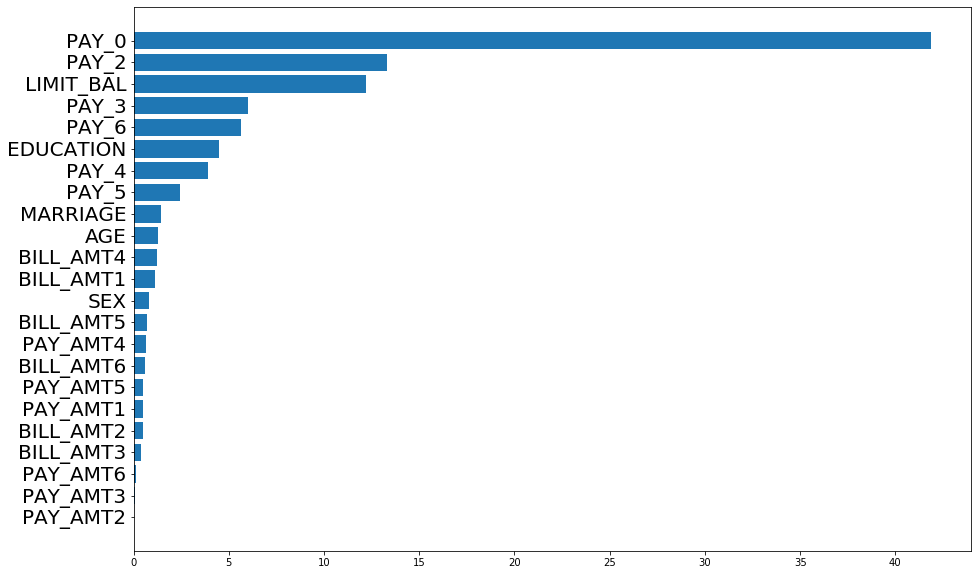

In [412]:
plt.subplots(figsize=(15,10))
idx = np.argsort(FeatureImportance)
plt.barh(range(len(totalvar)), FeatureImportance[idx])
plt.yticks(range(len(totalvar)),np.array(totalvar)[idx] ,fontsize= 20)
plt.show()

In [413]:
shuff_pred[0]

array([0.61289775, 0.29000273, 0.35106462, ..., 0.2955041 , 0.2567795 ,
       0.22527736], dtype=float32)

In [414]:
import random
np.random.seed(33)
random.seed(33)
id_ = 0
merge_pred = np.hstack([shuff_pred[id_], np.squeeze(original_prob)])
merge_pred

array([0.61289775, 0.29000273, 0.35106462, ..., 0.22248656, 0.26710835,
       0.19658065], dtype=float32)

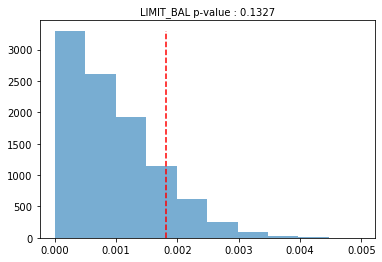

In [415]:
np.random.seed(33)
random.seed(33)
id_ = 0
merge_pred = np.hstack([shuff_pred[id_], np.squeeze(original_prob)])
observed_diff = abs(shuff_pred[id_].mean() - merge_pred.mean())
extreme_values = []
sample_d = []
for _ in range(10000):
    sample_mean = np.random.choice(merge_pred, size=shuff_pred[id_].shape[0]).mean()
    sample_diff = abs(sample_mean - merge_pred.mean())
    sample_d.append(sample_diff)
    extreme_values.append(sample_diff >= observed_diff)
y, x, _ = plt.hist(sample_d, alpha=0.6)
plt.vlines(observed_diff, 0,max(y), colors='red', linestyles='dashed')
plt.title(f"{totalvar[id_]} p-value : {np.sum(extreme_values)/10000}",fontsize=10)
plt.show()

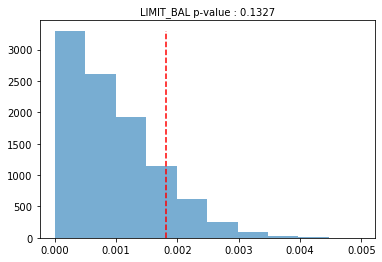

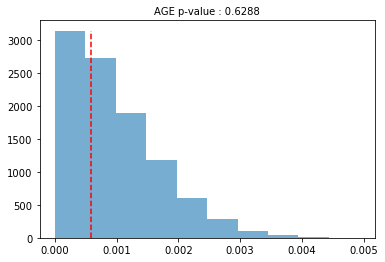

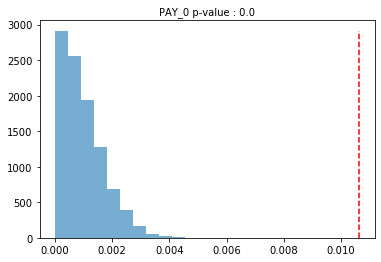

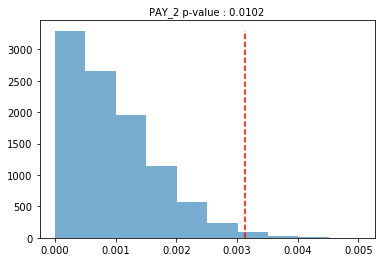

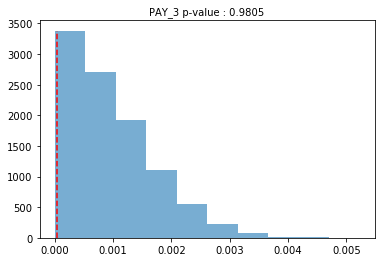

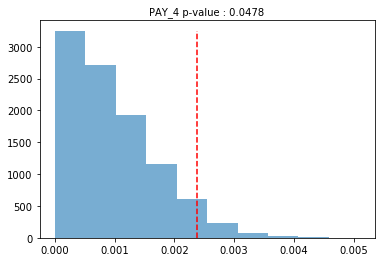

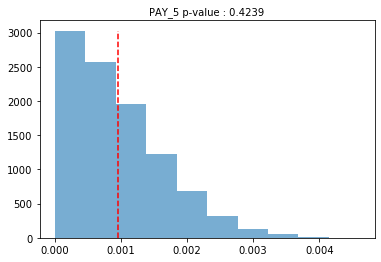

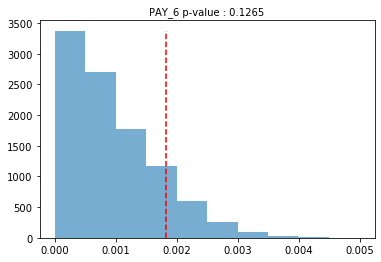

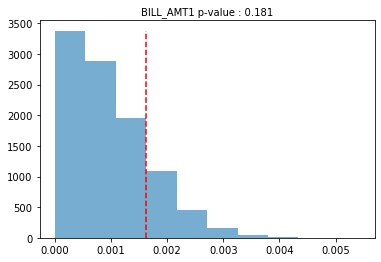

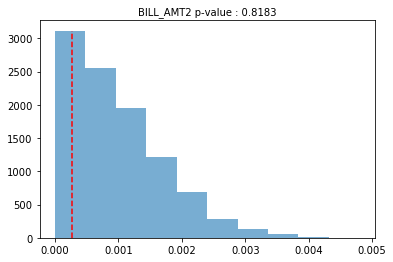

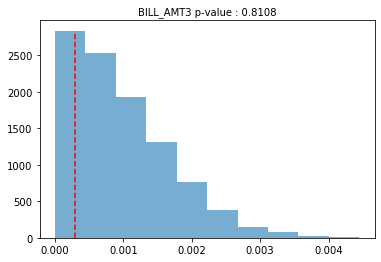

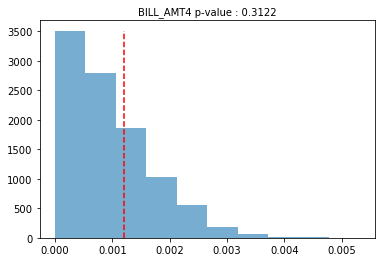

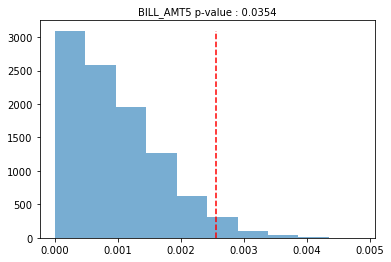

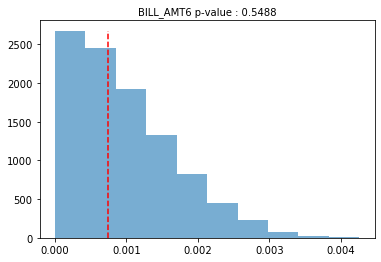

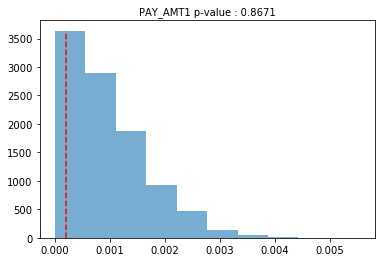

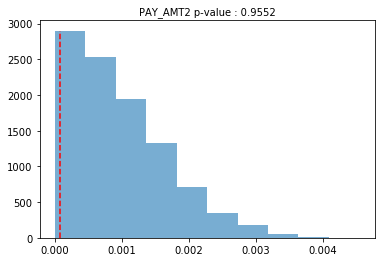

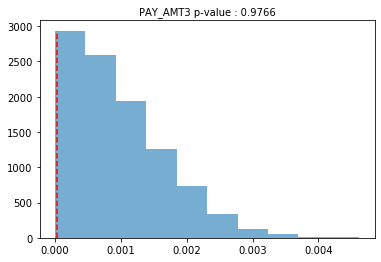

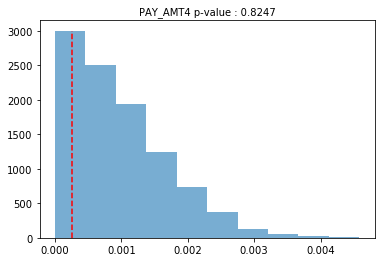

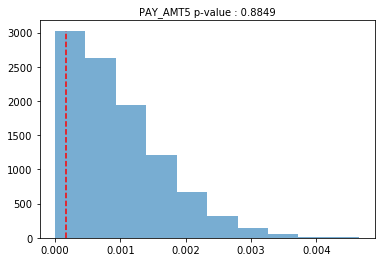

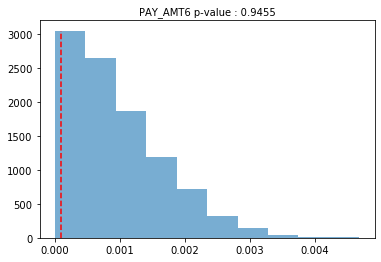

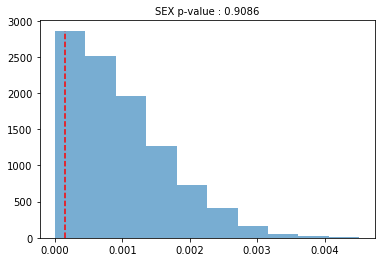

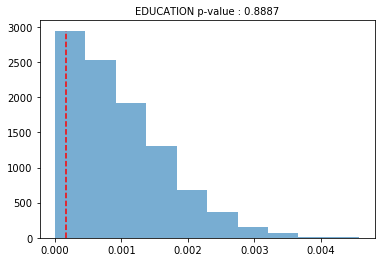

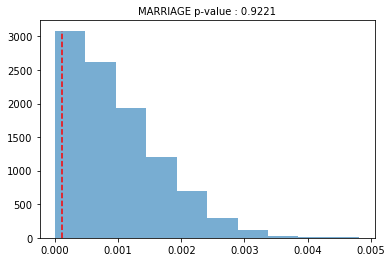

In [416]:
np.random.seed(33)
random.seed(33)
for id_ in range(len(totalvar)) :
    merge_pred = np.hstack([shuff_pred[id_], np.squeeze(original_prob)])
    observed_diff = abs(shuff_pred[id_].mean() - merge_pred.mean())
    extreme_values = []
    sample_d = []
    for _ in range(10000):
        sample_mean = np.random.choice(merge_pred, size=shuff_pred[id_].shape[0]).mean()
        sample_diff = abs(sample_mean - merge_pred.mean())
        sample_d.append(sample_diff)
        extreme_values.append(sample_diff >= observed_diff)
    y, x, _ = plt.hist(sample_d, alpha=0.6)
    plt.vlines(observed_diff, 0,max(y), colors='red', linestyles='dashed')
    plt.title(f"{totalvar[id_]} p-value : {np.sum(extreme_values)/10000}",fontsize=10)
    plt.show()